In [1]:
import numpy as np
import matplotlib.pyplot as plt
from parse import parse
import cv2

In [2]:
train_images, train_labels = parse('digitdata/trainingimages', 'digitdata/traininglabels', True)
validation_images, validation_labels = parse('digitdata/validationimages', 'digitdata/validationlabels', True)
test_images, test_labels = parse('digitdata/testimages', 'digitdata/testlabels', True)

In [64]:
base_rates = np.bincount(train_labels)/train_labels.shape[0]
print(base_rates)

[0.0958 0.1126 0.0976 0.0986 0.107  0.0868 0.1002 0.11   0.0924 0.099 ]


In [55]:
kernel = np.ones((3,3))
images = np.swapaxes(np.swapaxes(train_images.astype(np.float64), 0, 2), 0, 1)
dst = cv2.filter2D(src = images[:,:,0:512], ddepth = -1, kernel = kernel, anchor = (0, 0))
zones = dst[::3,::3,:]

In [ ]:
a = 0
plt.imshow(train_images[a,:,:])
plt.show()
plt.imshow(dst[:,:,a])
plt.show()
plt.imshow(zones[:,:,a])

In [112]:
def get_feature_probs(images = train_images, labels = train_labels, dim = (3,3), stride = -1, kernel = -1):

    labels = labels.astype(bool)

    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    pixel_quant = dim[0]*dim[1] + 1

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images.astype(np.float64), 0, 2), 0, 1)

    dst = np.zeros_like(images)

    if images.shape[2] > 512:
        for i in range(int(np.ceil(images.shape[2]/512))):
            dst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = images[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
    else:
        dst= cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))

    zone_probs = np.zeros((zones.shape[0], pixel_quant, base_rates.shape[0]))

    for i, zone in enumerate(zones):
        for number in range(0, base_rates.shape[0]):

            quant = np.bincount(zone[labels == number])

            quant = np.pad(quant, (0, pixel_quant - quant.shape[0]), constant_values = 0)

            if np.max(quant) != 0:
                zone_probs[i, :, number] = quant/np.sum(quant)

        zeros = zone_probs == 0
        zone_probs[zeros] = 0.000001

    return zone_probs

In [ ]:
def get_feature_probs(images = train_images, labels = train_labels, dim = (3,3), stride = -1, kernel = -1):

    labels = labels.astype(bool)

    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    pixel_quant = dim[0]*dim[1] + 1

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images.astype(np.float64), 0, 2), 0, 1)

    dst = np.zeros_like(images)

    if images.shape[2] > 512:
        for i in range(int(np.ceil(images.shape[2]/512))):
            dst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = images[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
    else:
        dst= cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))

    zone_probs = np.zeros((zones.shape[0], pixel_quant, base_rates.shape[0]))

    for i, zone in enumerate(zones):
        for number in range(0, base_rates.shape[0]):

            quant = np.bincount(zone[labels == number])

            quant = np.pad(quant, (0, pixel_quant - quant.shape[0]), constant_values = 0)

            if np.max(quant) != 0:
                zone_probs[i, :, number] = quant/np.sum(quant)

        zeros = zone_probs == 0
        zone_probs[zeros] = 0.000001

    return zone_probs

In [113]:
def get_features(images = train_images, dim = (3,3), stride = -1, kernel = -1):
    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images.astype(np.float64), 0, 2), 0, 1)

    dst = np.zeros_like(images)

    if images.shape[2] > 512:
        for i in range(int(np.ceil(images.shape[2]/512))):
            dst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = images[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
    else:
        dst= cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))

    return zones

In [124]:
def predict(train_images = train_images, train_labels = train_labels, val_images = validation_images, val_labels = validation_labels):
    dim = (1,1)

    base_rates = np.bincount(train_labels)/train_labels.shape[0]

    feature_probs = get_feature_probs(train_images, train_labels, dim, )
    train_features = get_features(train_images, dim)
    val_features = get_features(val_images, dim)

    train_image_probs = np.product(feature_probs[np.arange(len(train_features))[:, np.newaxis], train_features], axis = 0)
    train_preds = np.argmax(train_image_probs*base_rates, axis = 1)
    train_acc = np.sum(train_preds == train_labels)/train_labels.shape[0]

    val_image_probs = np.product(feature_probs[np.arange(len(val_features))[:, np.newaxis], val_features], axis = 0)
    val_preds = np.argmax(val_image_probs* base_rates, axis = 1)
    val_acc = np.sum(val_preds == val_labels)/val_labels.shape[0]

    return train_acc, val_acc


In [125]:
accuracy = np.zeros((10, 2), dtype= np.float64)
for i in range(1, 11):
    ammount = int(0.1 * i * train_images.shape[0] )
    available_indices = np.random.choice(train_images.shape[0], ammount, replace = False)
    available_images = train_images[available_indices]
    available_labels = train_labels[available_indices]
    accuracy[i-1] = np.array(predict(available_images, available_labels, validation_images, validation_labels))
print(accuracy[-1,:])

[0.2008 0.202 ]


[0.2008 0.202 ]


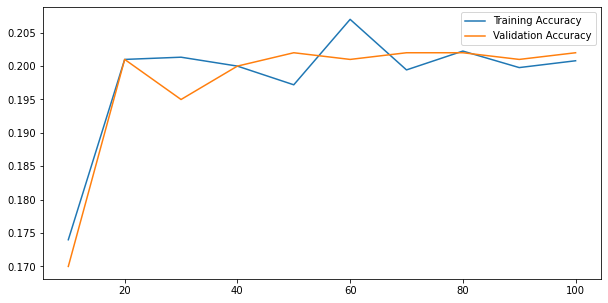

In [123]:
plt.figure(figsize = (10, 5))
x = np.linspace(10, 100, 10)
plt.plot(x, accuracy[:,0], label = "Training Accuracy")
plt.plot(x, accuracy[:,1], label = "Validation Accuracy")
plt.legend()
print(accuracy[-1,:])